In [4]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss, DDQN

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

import gym
import matplotlib.pyplot as plt

In [105]:
plt.rcParams.update({'font.size': 14})

In [99]:
# Best hyperparameter configuration 

#------------------------------------------------------#
#                   DID NOT CHANGE
#------------------------------------------------------#
NUM_RUNS = 10 # number of runs (fixed it)

num_episodes = 300 # number of episodes (fixed it)

#------------------------------------------------------#
#                       CHANGED
#------------------------------------------------------#
architecture = [4,32,2] # optimal network architecture

opt = 'Adam' # optimiser used to update the network weights using loss function

lr = 0.001 # initial learning rate inputted into optimiser

bf_size = 200000 # size of the Replay buffer memory (number of transitions stored)

memory_batch_sz = 32 # size of the sample batches drawn from the memory buffer for learning from experience

ifdecay = True # using decaying epsilon (exploration rate)

epsilon_init = 1 # initial value of the epsilon before the decay

decay_factor = 0.99 # rate of exponential decay

epsilon_limit = 0.1 # limit until which epsilon value decays

update_fqs = 5 # frequency of target value updates


In [100]:
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        EPSILON = epsilon_init
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()

        if opt == 'Adam': 
            optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        elif opt == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr)
        
        memory = ReplayBuffer(bf_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(num_episodes):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            
            if ifdecay:
                if EPSILON > epsilon_limit:
                    EPSILON = EPSILON * decay_factor
            else: 
                EPSILON = epsilon_init


            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < memory_batch_sz:
                    transitions = memory.sample(memory_batch_sz)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_fqs == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
        
    print('Complete')

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

In [106]:
# Turn the learning code placeholder into a function for convenience 
def plot_learning_curve(runs_results):
    plt.figure(figsize=(9, 4))
    num_episodes = 300
    results = torch.tensor(runs_results)
    means = results.float().mean(0)
    stds = results.float().std(0)

    plt.plot(torch.arange(300), means)
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.plot([0,num_episodes],[100,100], color = 'r')
    plt.fill_between(np.arange(300), means, means+stds, alpha=0.3, color='b')
    plt.fill_between(np.arange(300), means, means-stds, alpha=0.3, color='b')
    plt.show()

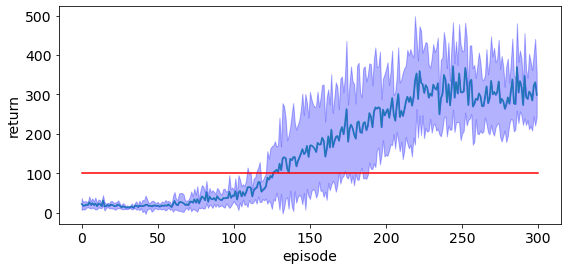

In [107]:
plot_learning_curve(runs_results)

In [16]:
# Turn the above code provided into a function for convenience. Select the optimal identified hyperparams as default

# ifmemory - if true, outputs all of the states experienced by agent
# ifdecay - if true, enables epsilon (exploration rate) decay, starting from 'epsilon_init', using 
#           decay rate 'decay_factor', and stops when epsilon reaches a value specified by 'epsilon_limit'


def run_simulation(NUM_RUNS = 10,
                   bf_size = 200000,
                   lr = 0.001,
                   memory_batch_sz = 32,
                   decay_factor = 0.99,
                   epsilon_init = 1,
                   num_episodes = 300,
                   architecture = [4,32,2],
                   update_fqs = 5, 
                   opt = 'Adam', 
                   epsilon_limit = 0.1,
                   ifdecay = True, 
                   ifmemory = False):

    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        EPSILON = epsilon_init
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DQN(architecture)
        target_net = DQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()
        
        if opt == 'Adam': 
            optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        elif opt == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr)
            
        memory = ReplayBuffer(bf_size)
        
        
        all_memory = [[],[]]
        
        steps_done = 0

        episode_durations = []

        for i_episode in range(num_episodes):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)

            observation, info = env.reset()
            
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            
            if ifdecay:
                if EPSILON > epsilon_limit:
                    EPSILON = EPSILON * decay_factor
            else: 
                EPSILON = epsilon_init



            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)
                if ifmemory:
                    #if -0.5 <observation[0]< 0.5:
                    all_memory[0].append(observation[0])
                    all_memory[1].append(observation[1])
                        
                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])
                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < memory_batch_sz:
                    transitions = memory.sample(memory_batch_sz)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_fqs == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
        
    print('Complete')
    if ifmemory:
        return runs_results, policy_net, target_net, all_memory
    else: 
        return runs_results, policy_net, target_net

In [151]:
run_results, policy_net, target_net = run_simulation()


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

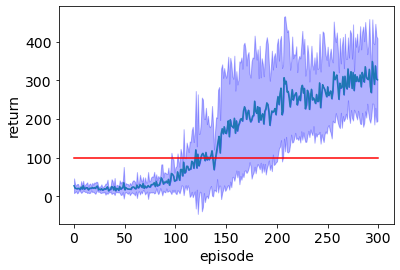

In [152]:
plot_learning_curve(run_results)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

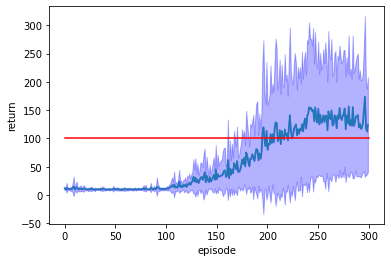

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

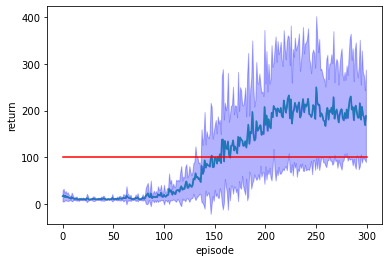

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

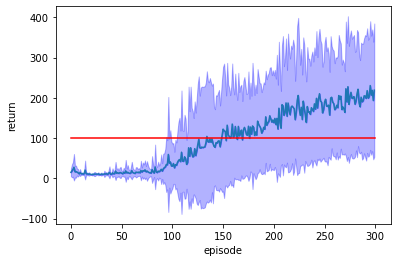

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

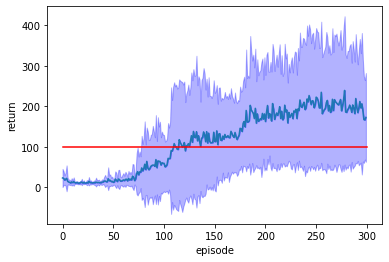

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

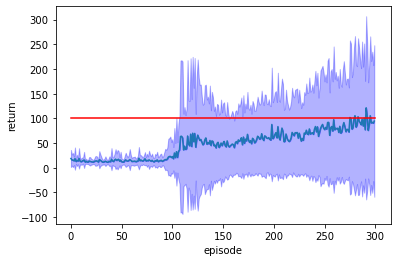

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

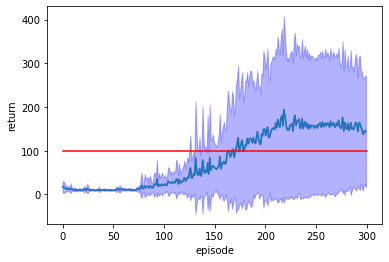

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

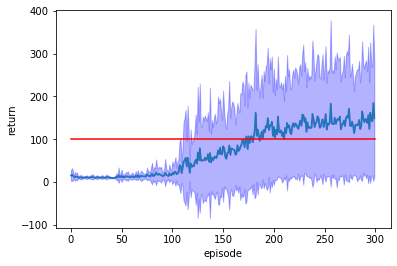

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

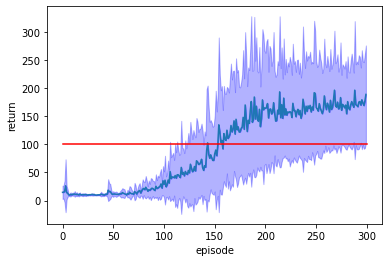

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

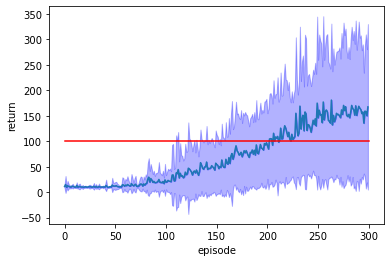

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

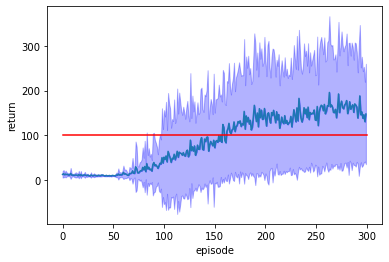

In [67]:
# check whether the chosen parameters are fulfilling the criteria consistently
for i in range(10):
    run_results, policy_net, target_net = run_simulation()
    plot_learning_curve(run_results)

# Trying different architectures 


In [28]:

# Plotting the learning curve
# Placeholder plot, you are free to modify it
def plot_compare_hyperparams(run_results_list, params_list, params_str, ifstd = False):
    num_episodes = 300
    plt.figure(figsize=(9, 4))
    fill_color = ['blue', 'orange', 'green', 'red', 'purple', 'yellow']
    for i in range(len(run_results_list)):
        results = torch.tensor(run_results_list[i])
        means_res = results.float().mean(0)
        stds = results.float().std(0)
        lbl_msg = params_str + f' = {params_list[i]}'
        plt.plot(torch.arange(300), means_res, label = lbl_msg)
        plt.ylabel("return")
        plt.xlabel("episode")
        plt.plot([0,num_episodes],[100,100], color = 'r')
        if ifstd: 
            plt.fill_between(np.arange(300), means_res, means_res+stds, alpha=0.3, color = fill_color[i])
            plt.fill_between(np.arange(300), means_res, means_res-stds, alpha=0.3, color = fill_color[i])
    plt.legend(fontsize = 10)
    plt.show()

In [73]:
# Trying different number of layers - 32

layers_list = [[4,2], [4,32,2], [4,32,32,2], [4, 32, 32, 32, 2]]


run_results_layers = []
policy_nets_layers = []
target_nets_layers = []

for architecture in layers_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                            bf_size = 200000,
                                                                lr = 0.001,
                                                                memory_batch_sz = 32,
                                                                decay_factor = 0.99,
                                                                epsilon_init = 1,
                                                                num_episodes = 300,
                                                                architecture = architecture,
                                                                update_fqs = 5,
                                                                opt = 'Adam',
                                                                epsilon_limit = 0.1, 
                                                                ifdecay = True
                                                                )
    run_results_layers.append(run_results_i)
    policy_nets_layers.append(policy_net_i)
    target_nets_layers.append(target_net_i)

    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

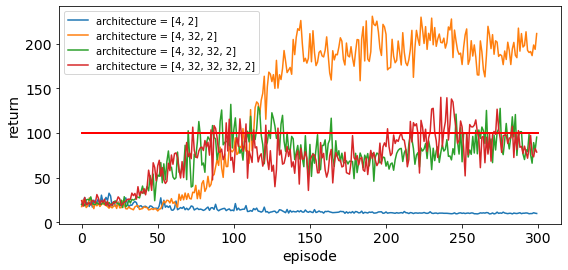

In [111]:
plot_compare_hyperparams(run_results_layers, layers_list, 'architecture')

In [98]:
# Trying different number of neurons

neurons_list = [[4,16,2], [4,32,2], [4,64,2]]


run_results_neurons = []
policy_nets_neurons = []
target_nets_neurons = []

for architecture in neurons_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = architecture,
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True
                                                        )
    run_results_neurons.append(run_results_i)
    policy_nets_neurons.append(policy_net_i)
    target_nets_neurons.append(target_net_i)

    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

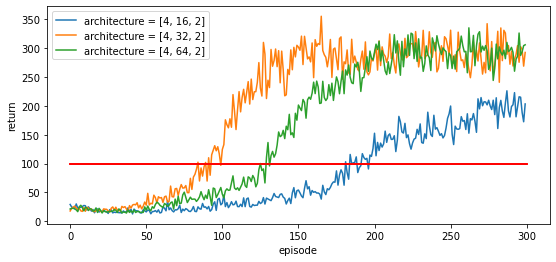

In [102]:
plot_compare_hyperparams(run_results_neurons, neurons_list, 'architecture')

## Question 1.2: Trying different epsilon limits and epsilon decay rate for epsilon decay


In [117]:
# trying with fixed epsilon and with epsilon decay 
run_results_fixed, policy_net_fixed, target_net_fixed = run_simulation(NUM_RUNS = 10,
                                                                        bf_size = 200000,
                                                                        lr = 0.001,
                                                                        memory_batch_sz = 32,
                                                                        decay_factor = 0.99,
                                                                        epsilon_init = 0.6,
                                                                        num_episodes = 300,
                                                                        architecture = [4,32,2],
                                                                        update_fqs = 5, 
                                                                        opt = 'Adam', 
                                                                        epsilon_limit = 0.1,
                                                                        ifdecay = False
                                                                        )
run_results_decay, policy_net_decay, target_net_decay = run_simulation(NUM_RUNS = 10,
                                                                        bf_size = 200000,
                                                                        lr = 0.001,
                                                                        memory_batch_sz = 32,
                                                                        decay_factor = 0.99,
                                                                        epsilon_init = 1,
                                                                        num_episodes = 300,
                                                                        architecture = [4,32,2],
                                                                        update_fqs = 5, 
                                                                        opt = 'Adam', 
                                                                        epsilon_limit = 0.1,
                                                                        ifdecay = True
                                                                        )

results_list = [run_results_fixed, run_results_decay]
param_list = ['0.6', 'decaying']

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

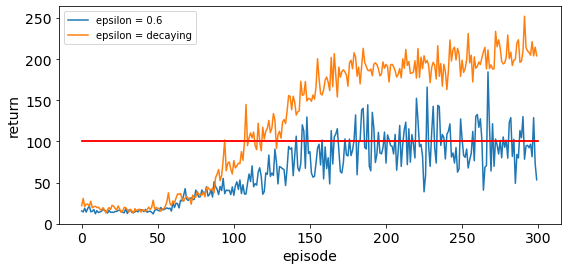

In [118]:
plot_compare_hyperparams(results_list, param_list, 'epsilon')

In [121]:
# trying with fixed epsilon (extreme cases)
run_results_fixed_0, policy_net_fixed_0, target_net_fixed_0 = run_simulation(NUM_RUNS = 10,
                                                                        bf_size = 200000,
                                                                        lr = 0.001,
                                                                        memory_batch_sz = 32,
                                                                        decay_factor = 0.99,
                                                                        epsilon_init = 0,
                                                                        num_episodes = 300,
                                                                        architecture = [4,32,2],
                                                                        update_fqs = 5, 
                                                                        opt = 'Adam', 
                                                                        epsilon_limit = 0.1,
                                                                        ifdecay = False
                                                                        )

# trying with fixed epsilon and with epsilon decay 
run_results_fixed_1, policy_net_fixed_1, target_net_fixed_1 = run_simulation(NUM_RUNS = 10,
                                                                        bf_size = 200000,
                                                                        lr = 0.001,
                                                                        memory_batch_sz = 32,
                                                                        decay_factor = 0.99,
                                                                        epsilon_init = 1,
                                                                        num_episodes = 300,
                                                                        architecture = [4,32,2],
                                                                        update_fqs = 5, 
                                                                        opt = 'Adam', 
                                                                        epsilon_limit = 0.1,
                                                                        ifdecay = False
                                                                        )

results_list = [run_results_fixed_0, run_results_fixed, run_results_fixed_1, run_results_decay]
param_list = ['0', '0.6', '1','decaying']

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

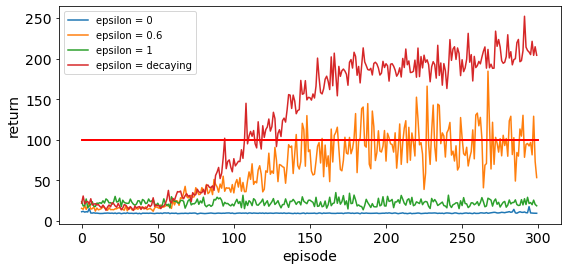

In [122]:
plot_compare_hyperparams(results_list, param_list, 'epsilon')

In [124]:
# Trying different epsilon limits

limit_list = [0, 0.1, 0.2, 0.5, 1]

# 0 takes forever to run!!!


run_results_eps_lim = []
policy_nets_eps_lim = []
target_nets_eps_lim = []

for epsilon_limit in limit_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = epsilon_limit,
                                                        ifdecay = True
                                                        )
    run_results_eps_lim.append(run_results_i)
    policy_nets_eps_lim.append(policy_net_i)
    target_nets_eps_lim.append(target_net_i)

    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

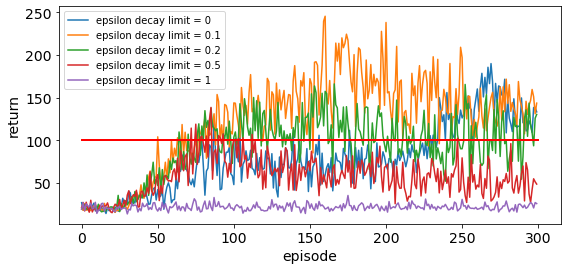

In [125]:
plot_compare_hyperparams(run_results_eps_lim, limit_list, 'epsilon decay limit')

In [128]:
# Trying different epsilon decay rates

decay_list = [0.2, 0.5, 0.99]


run_results_decay_rt = []
policy_nets_decay_rt = []
target_nets_decay_rt = []

for eps_decay in decay_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = eps_decay,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True
                                                        )
    run_results_decay_rt.append(run_results_i)
    policy_nets_decay_rt.append(policy_net_i)
    target_nets_decay_rt.append(target_net_i)

    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

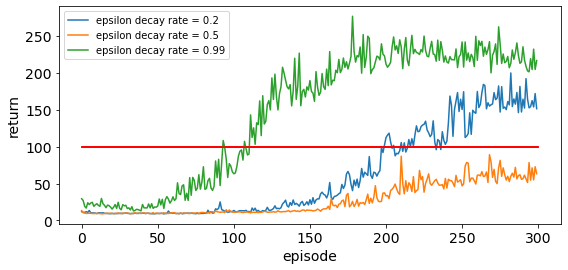

In [129]:
plot_compare_hyperparams(run_results_decay_rt, decay_list, 'epsilon decay rate')

## Trying different learning rates

In [137]:
lr_list = [0, 0.0001 , 0.001, 0.01, 0.1, 1]

run_results_lrs = []
policy_nets_lrs = []
target_nets_lrs = []

for lr in lr_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = lr,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True)
    run_results_lrs.append(run_results_i)
    policy_nets_lrs.append(policy_net_i)
    target_nets_lrs.append(target_net_i)

    

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

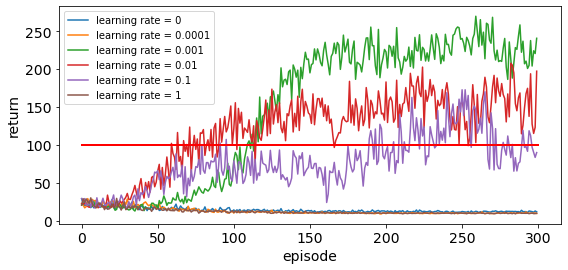

In [138]:
plot_compare_hyperparams(run_results_lrs, lr_list, 'learning rate')

## Trying different buffer sizes

In [78]:
bf_list = [50000, 100000, 200000, 300000]
# 50000 - very slow 
run_results_bfs = []
policy_nets_bfs = []
target_nets_bfs = []

for bf_size in bf_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = bf_size,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True)
    run_results_bfs.append(run_results_i)
    policy_nets_bfs.append(policy_net_i)
    target_nets_bfs.append(target_net_i)



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

In [80]:
bf_list_final  = [0, 5000, 50000, 100000, 200000, 300000]

In [75]:
bf_list2 = [0, 5000]

run_results_bfs2 = []
policy_nets_bfs2 = []
target_nets_bfs2 = []

for bf_size in bf_list2: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = bf_size,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam', 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True)
    run_results_bfs2.append(run_results_i)
    policy_nets_bfs2.append(policy_net_i)
    target_nets_bfs2.append(target_net_i)



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

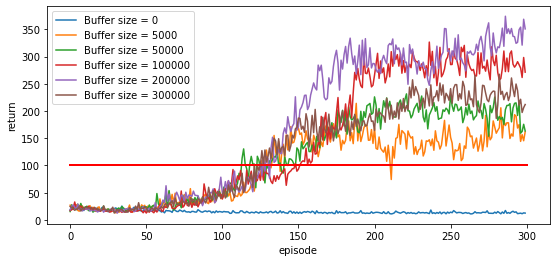

In [82]:
plot_compare_hyperparams(run_results_bfs2+ run_results_bfs, bf_list_final, 'Buffer size')

## Trying different memory batch sizes

In [91]:
memory_batch_list = [1, 16, 32, 64, 128, 256]

run_results_batch = []
policy_nets_batch = []
target_nets_batch = []

for memory_batch_sz in memory_batch_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = memory_batch_sz,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = 'Adam')
    run_results_batch.append(run_results_i)
    policy_nets_batch.append(policy_net_i)
    target_nets_batch.append(target_net_i)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

KeyboardInterrupt: 

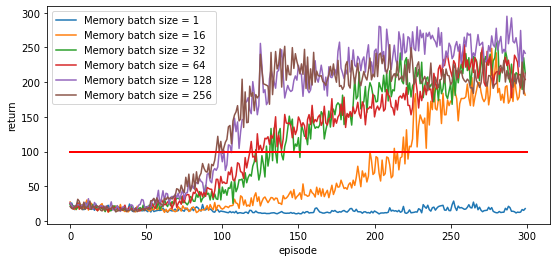

In [90]:
plot_compare_hyperparams(run_results_batch, memory_batch_list, 'Memory batch size')

## Trying different update frequency

In [148]:
fq_list = [2, 5, 10]

run_results_fq = []
policy_nets_fq = []
target_nets_fq = []

for update_fq in fq_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = update_fq, 
                                                        opt = 'Adam')
    run_results_fq.append(run_results_i)
    policy_nets_fq.append(policy_net_i)
    target_nets_fq.append(target_net_i)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

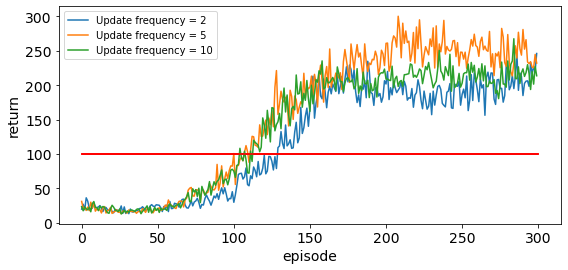

In [149]:
plot_compare_hyperparams(run_results_fq, fq_list, 'Update frequency')

## Trying two different optimisers: Adam and SGD

In [132]:
opt_list = ['Adam', 'SGD']

run_results_opt = []
policy_nets_opt = []
target_nets_opt = []

for opt in opt_list: 
    run_results_i, policy_net_i, target_net_i = run_simulation(NUM_RUNS = 10,
                                                        bf_size = 200000,
                                                        lr = 0.001,
                                                        memory_batch_sz = 32,
                                                        decay_factor = 0.99,
                                                        epsilon_init = 1,
                                                        num_episodes = 300,
                                                        architecture = [4,32,2],
                                                        update_fqs = 5, 
                                                        opt = opt, 
                                                        epsilon_limit = 0.1,
                                                        ifdecay = True)
    run_results_opt.append(run_results_i)
    policy_nets_opt.append(policy_net_i)
    target_nets_opt.append(target_net_i)

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

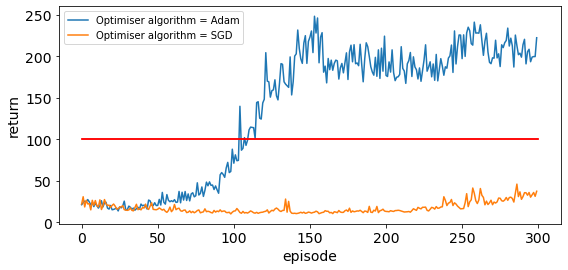

In [133]:
plot_compare_hyperparams(run_results_opt, opt_list, 'Optimiser algorithm')

# Question 2

Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete


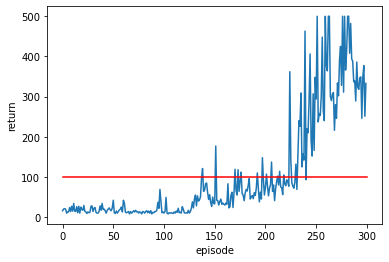

In [76]:
# ensure we choose a run where we get a good policy

run_results, policy_net, target_net = run_simulation(NUM_RUNS = 1)   
plot_learning_curve(run_results)


In [77]:
run_results_opt = run_results
policy_net_opt = policy_net
target_net_opt = target_net


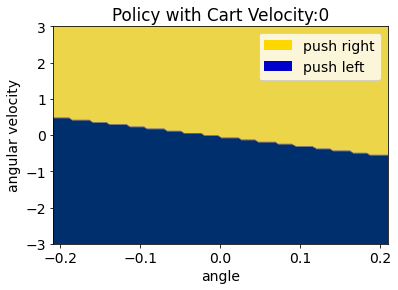

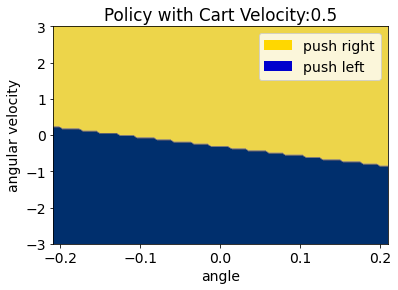

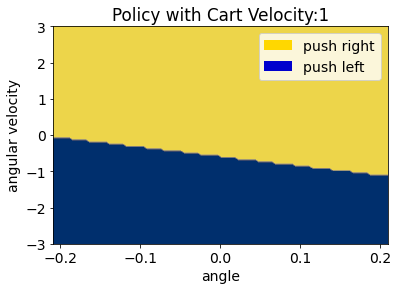

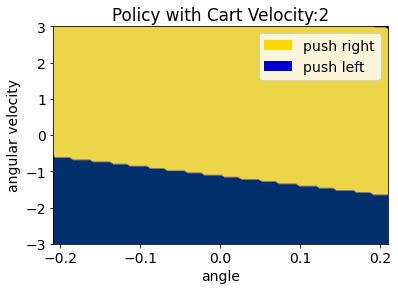

In [165]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot


#policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN

policy_net = policy_net_opt
for cart_velocity in [0,0.5,1,2]:
    q = False    # whether q values or greedy policy is visualised

    angle_range = .2095 # you may modify this range
    omega_range = 3     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        proxy = [plt.Rectangle((0, 0), 1, 1, fc='gold'),
                 plt.Rectangle((0, 0), 1, 1, fc='mediumblue')                                                       ]
        

        plt.legend(proxy, ["push right", "push left"])



    plt.title(f'Policy with Cart Velocity:{cart_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

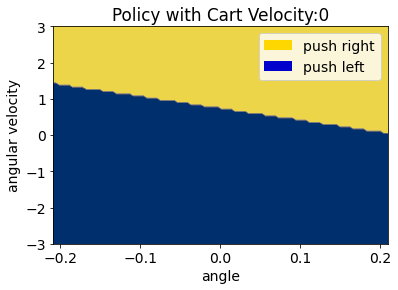

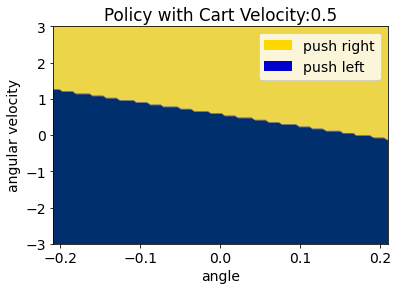

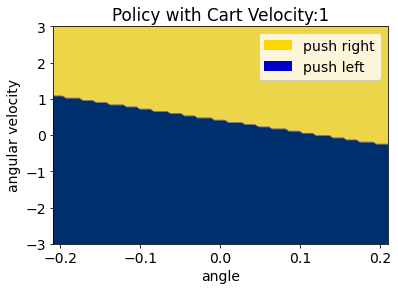

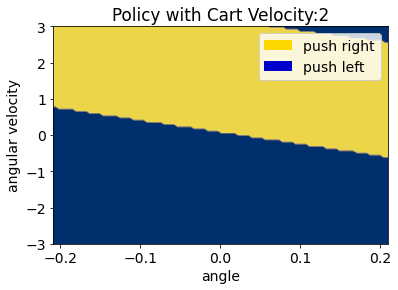

In [91]:
# position 2 of the cart 

#policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN

policy_net = policy_net_opt
for cart_velocity in [0,0.5,1,2]:
    q = False    # whether q values or greedy policy is visualised

    angle_range = .2095 # you may modify this range
    omega_range = 3     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([2.39, cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        proxy = [plt.Rectangle((0, 0), 1, 1, fc='gold'),
                 plt.Rectangle((0, 0), 1, 1, fc='mediumblue')                                                       ]
        

        plt.legend(proxy, ["push right", "push left"])



    plt.title(f'Policy with Cart Velocity:{cart_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

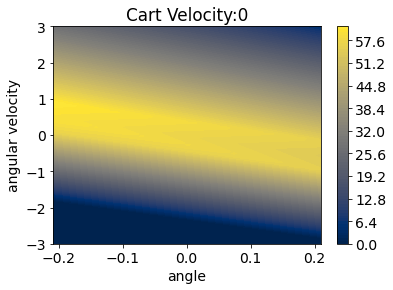

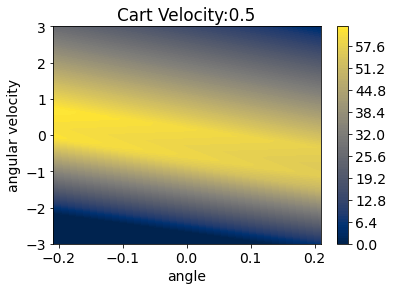

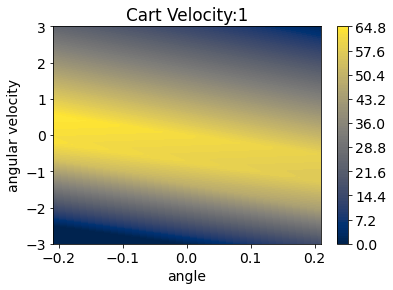

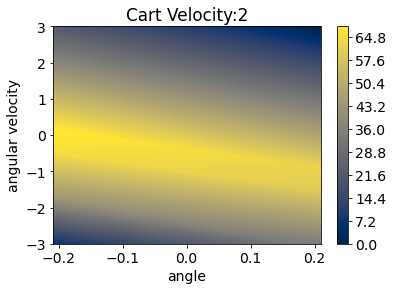

In [167]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

#policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
policy_net = policy_net_opt
for cart_velocity in [0,0.5,1,2]:
    q = True   # whether q values or greedy policy is visualised

    angle_range = .2095 # you may modify this range
    omega_range = 3     # you may modify this range

    angle_samples = 100
    omega_samples = 100
    angles = torch.linspace(angle_range, -angle_range, angle_samples)
    omegas = torch.linspace(-omega_range, omega_range, omega_samples)

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., cart_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    
    plt.title(f'Cart Velocity:{cart_velocity}')
    plt.colorbar()
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

In [34]:
def visualise_policy_q(policy_net, ifqvalue):
    
    

    # Visualising the greedy Q-values for a stationary cart in the middle of the track
    # 2D plot showing policy as a function of pole angle and angular velocity (omega)

    # This plots the policy and Q values according to the network currently
    # stored in the variable "policy_net"

    # All visualisations provided here are placeholders and you can modify these plots

    # Make sure to include appropriate labels and/or legends when presenting your plot

    #policy_net = DQN([4,2])   # randomly initialised, replace with your trained DQN
    
    for cart_velocity in [0,0.5,1,2]:
        q = ifqvalue   # whether q values or greedy policy is visualised

        angle_range = .2095 # you may modify this range
        omega_range = 3     # you may modify this range

        angle_samples = 100
        omega_samples = 100
        angles = torch.linspace(angle_range, -angle_range, angle_samples)
        omegas = torch.linspace(-omega_range, omega_range, omega_samples)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, angle in enumerate(angles):
            for j, omega in enumerate(omegas):
                state = torch.tensor([0., cart_velocity, angle, omega])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
        if q:
            plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        else:
            plt.contourf(angles, omegas, policy_array.T, cmap='cividis')

        plt.title(f'Cart Velocity:{cart_velocity}')
        
        if q:
            plt.colorbar()
        plt.xlabel("angle")
        plt.ylabel("angular velocity")
        plt.show()

In [17]:
# Getting the states explored by the agent from one run to see which velocities and distances from the
# origin has been experienced by the agent

# got the data from 10 runs
memory_opt_all = [[],[]]
for i in range(10):
    runs_results_opt, policy_net_opt, target_net_opt, memory_opt = run_simulation(NUM_RUNS = 1, ifmemory = True)
    memory_opt_all[0].append(memory_opt[0])
    memory_opt_all[1].append(memory_opt[1])

Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete
Starti

In [22]:
velocity = []
position = []
for i in range(len(memory_opt_all[0])):
    velocity  = velocity + memory_opt_all[1][i]
    position  = position + memory_opt_all[0][i]
    


In [87]:
# Extracted the data from just one run

velocity1 = memory_opt_all[1][1]
position1 = memory_opt_all[0][1]

In [108]:
len(velocity1)

48908

In [147]:
position1_numpy = np.array(position1)
velocity1_numpy = np.array(velocity1)

In [117]:
position1_numpy[:]

(48908,)

In [139]:
a = np.where(abs(position1_numpy)<0.1)

In [142]:
a[0].shape


(16939,)

In [148]:
velocity_at_origin = velocity1_numpy[a[0]]

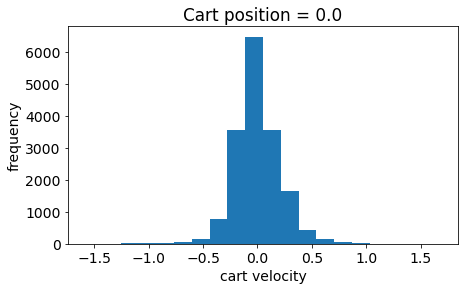

In [150]:
# build a histogram of velocities at the origin 

plt.figure(figsize=(7, 4))
plt.hist(velocity_at_origin, bins  = 20)
plt.xlabel("cart velocity")
plt.ylabel("frequency")
plt.title("Cart position = 0.0")
plt.show()

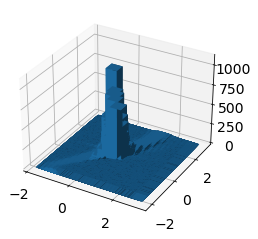

In [151]:
# Trying to see how 3D histogram looks like 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
hist, xedges, yedges = np.histogram2d(velocity1, position1, bins=100)

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

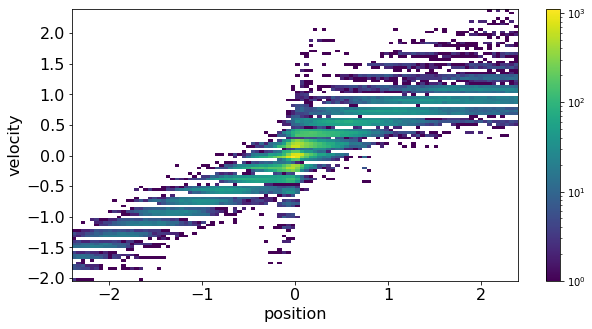

In [89]:
# 2D histogram-colormap that tells how frequently an agent encounters a state with 
# varrying positions and cart velocities


import matplotlib.colors as colors

plt.figure(figsize=(10, 5))

plt.hist2d(position1, velocity1, bins=100 , norm = colors.LogNorm())

#plt.pcolormesh(position, velocity, h,  norm=norm, cmap='PuBu_r', shading='nearest')
cb = plt.colorbar()

plt.xlabel('position', fontsize = 16)
plt.ylabel('velocity', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

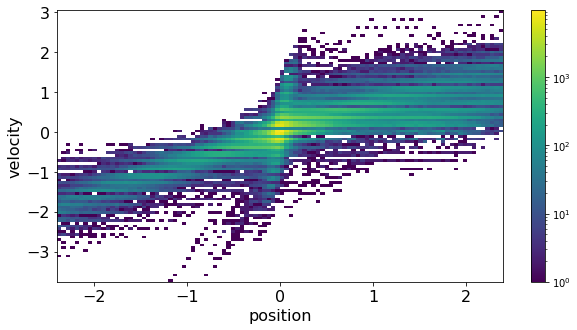

In [88]:
# Histogram for explored states across 10 runs
import matplotlib.colors as colors

plt.figure(figsize=(10, 5))

plt.hist2d(position, velocity, bins=100 , norm = colors.LogNorm())

#plt.pcolormesh(position, velocity, h,  norm=norm, cmap='PuBu_r', shading='nearest')
cb = plt.colorbar()

plt.xlabel('position', fontsize = 16)
plt.ylabel('velocity', fontsize = 16)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

plt.show()

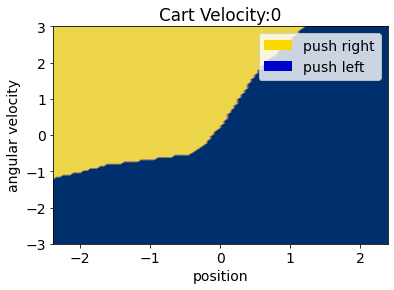

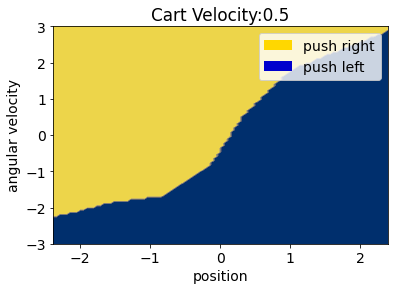

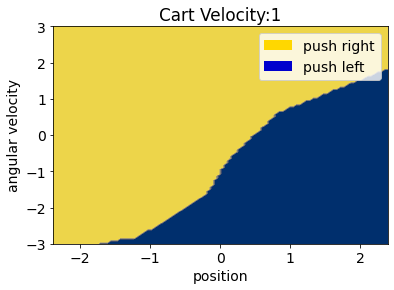

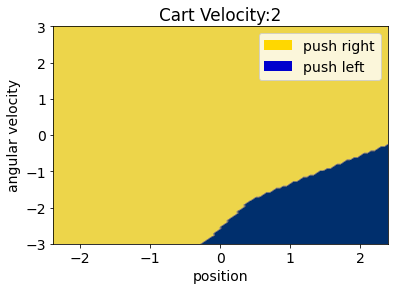

In [156]:
# Modified to see how the policy of the agent depends on the cart position and the angle 

ifqvalue = False

for cart_velocity in [0,0.5,1,2]:
        q = ifqvalue   # whether q values or greedy policy is visualised

        angle_range = .2095 
        positions_range = 2.39
        
        
        angle_samples = 100
        positions_sample = 100
        angles = torch.linspace(-angle_range, angle_range, angle_samples)
        positions = torch.linspace(-positions_range, positions_range, positions_sample)

        greedy_q_array = torch.zeros((angle_samples, omega_samples))
        policy_array = torch.zeros((angle_samples, omega_samples))
        for i, position in enumerate(positions):
            for j, angle in enumerate(angles):
                state = torch.tensor([position, cart_velocity, angle, 0.])
                with torch.no_grad():
                    q_vals = policy_net(state)
                    greedy_action = q_vals.argmax()
                    greedy_q_array[i, j] = q_vals[greedy_action]
                    policy_array[i, j] = greedy_action
        if q:
            plt.contourf(positions, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        else:
            plt.contourf(positions, omegas, policy_array.T, cmap='cividis')
            proxy = [plt.Rectangle((0, 0), 1, 1, fc='gold'),
            plt.Rectangle((0, 0), 1, 1, fc='mediumblue')                                                       ]
        

        plt.legend(proxy, ["push right", "push left"])

        plt.title(f'Cart Velocity:{cart_velocity}')
        
        if q:
            plt.colorbar()
        plt.xlabel("position")
        plt.ylabel("angular velocity")
        plt.show()

In [ ]:
sums, xbins, ybins = np.histogram2d(memory_opt[0], memory_opt[1, bins=100, weights=z)
counts, _, _ = np.histogram2d(x, y, bins=bins)
with np.errstate(divide='ignore', invalid='ignore'):
    # suppress possible divide-by-zero warnings
    img = axs[1].pcolormesh(xbins, ybins, sums / counts, cmap='inferno')
fig.colorbar(img, ax=axs[1], label='z')
axs[1].set(xlabel='x', ylabel='y', title='weighed by z')

# Question 3

In [4]:
# Turn the above code provided into a function for running DDQN for convenience. 
# Select the optimal identified params as default

def run_simulation_DDQN(NUM_RUNS = 10,
                   bf_size = 200000,
                   lr = 0.001,
                   memory_batch_sz = 32,
                   decay_factor = 0.99,
                   epsilon_init = 1,
                   num_episodes = 300,
                   architecture = [4,32,2],
                   update_fqs = 5, 
                   opt = 'Adam', 
                   epsilon_limit = 0.1,
                   ifdecay = True):

    runs_results = []

    env = gym.make('CartPole-v1')
    for run in range(NUM_RUNS):
        EPSILON = epsilon_init
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_net = DDQN(architecture)
        target_net = DDQN(architecture)
        update_target(target_net, policy_net)
        target_net.eval()
        
        if opt == 'Adam': 
            optimizer = optim.Adam(policy_net.parameters(), lr=lr)
        elif opt == 'SGD':
            optimizer = optim.SGD(policy_net.parameters(), lr=lr)
            
        memory = ReplayBuffer(bf_size)

        steps_done = 0

        episode_durations = []

        for i_episode in range(num_episodes):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", 300)

            observation, info = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            
            if ifdecay:
                if EPSILON > epsilon_limit:
                    EPSILON = EPSILON * decay_factor
            else: 
                EPSILON = epsilon_init



            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)

                observation, reward, done, terminated, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < memory_batch_sz:
                    transitions = memory.sample(memory_batch_sz)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % update_fqs == 0: 
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
        
    print('Complete')
    return runs_results, policy_net, target_net

In [5]:
runs_results_ddqn, policy_net_ddqn, target_net_ddqn = run_simulation_DDQN()


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

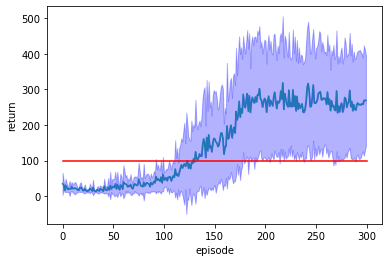

In [11]:
plot_learning_curve(runs_results_ddqn)

In [15]:
runs_results_dqn, policy_net_dqn, target_net_dqn = run_simulation()

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

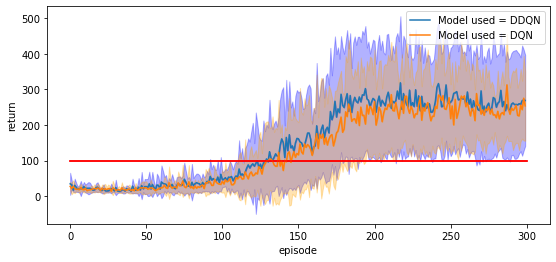

In [99]:
plot_compare_hyperparams([runs_results_ddqn, runs_results_dqn], ['DDQN', 'DQN'], 'Model used', ifstd = True)

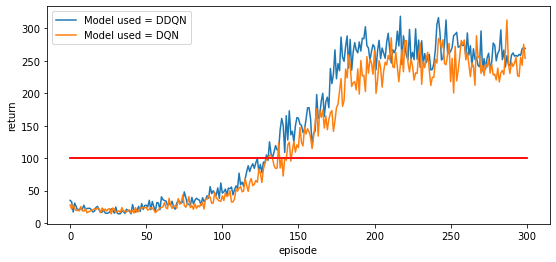

In [30]:
plot_compare_hyperparams([runs_results_ddqn, runs_results_dqn], ['DDQN', 'DQN'], 'Model used', ifstd = False)

Starting run 1 of 1
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete


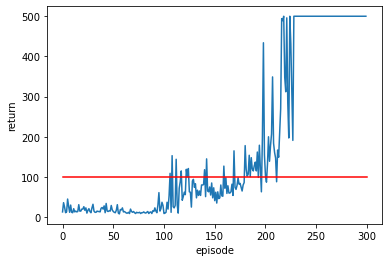

In [67]:
# ensure we choose a run where we get a good policy

run_results_ddqn_1, policy_net_ddqn_1, target_net_ddqn_1 = run_simulation_DDQN(NUM_RUNS = 1)   
plot_learning_curve(run_results_ddqn_1)

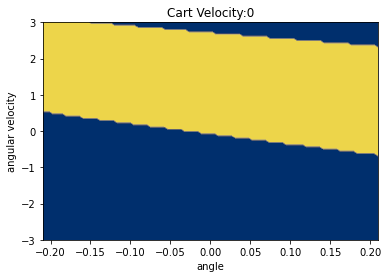

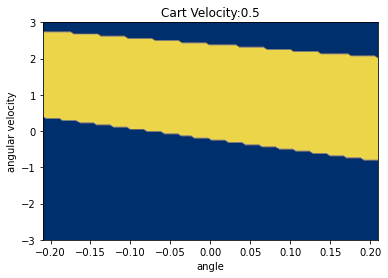

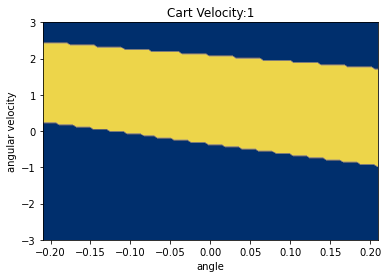

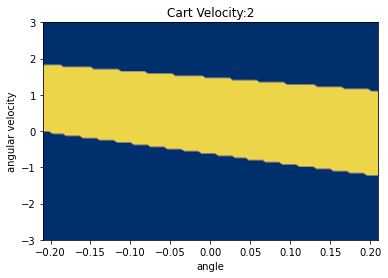

In [69]:
visualise_policy_q(policy_net_ddqn_1, ifqvalue = False)

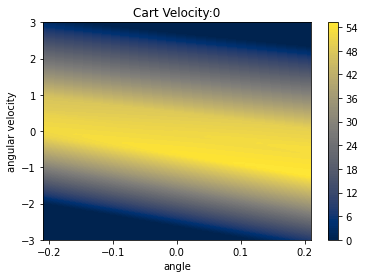

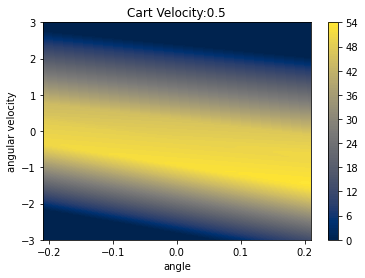

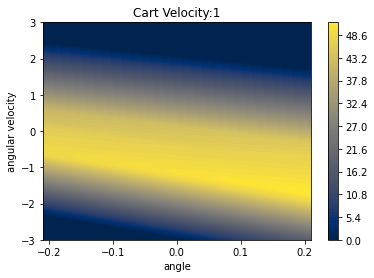

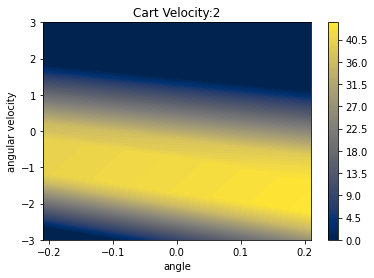

In [70]:
visualise_policy_q(policy_net_ddqn_1, ifqvalue = True)